In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-08-06 18:53:33.207757: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-06 18:53:33.235649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  3037k      0  0:04:25  0:04:25 --:--:-- 2467k


In [2]:
# sudo apt install unzip
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      NPetImages   kagglecatsanddogs_5340.zip
 CatDog_Image_Classfi.ipynb   PetImages   'readme[1].txt'


In [2]:
!ls PetImages

Cat  Dog


In [3]:
#너무많아서 1/20 수준으로 데이터 축약(주피터노트북 메모리 할당오류 문제)
import os

In [4]:
cat_file_list = os.listdir('PetImages/Cat')
cat_file_count = len(cat_file_list)
print(cat_file_count)

12501


In [5]:
dog_file_list = os.listdir('PetImages/Dog')
dog_file_count = len(dog_file_list)
print(dog_file_count)

12501


In [6]:
cat_cnt = round(cat_file_count*0.005)
dog_cnt = round(dog_file_count*0.005)

In [7]:
print(cat_cnt, dog_cnt)

63 63


In [8]:
cats_5per_dir = os.path.join('NPetImages', 'Cat') #'NPetImages' 폴더에 'Cat' 생성
# Make a path directory
os.mkdir(cats_5per_dir)

In [9]:
import shutil
fnames = ['{}.jpg'.format(i) for i in range(cat_cnt)]

for fname in fnames:
    src = os.path.join('PetImages/Cat', fname)
    dst = os.path.join(cats_5per_dir, fname)
    shutil.copyfile(src, dst)

In [10]:
dogs_5per_dir = os.path.join('NPetImages', 'Dog') #'NPetImages' 폴더에 'Cat' 생성
# Make a path directory
os.mkdir(dogs_5per_dir)

In [11]:
fnames = ['{}.jpg'.format(i) for i in range(dog_cnt)]

for fname in fnames:
    src = os.path.join('PetImages/Dog', fname)
    dst = os.path.join(dogs_5per_dir, fname)
    shutil.copyfile(src, dst)

In [12]:
#폴더명 변경
os.rename('PetImages','PetImages_Old')
os.rename('NPetImages','PetImages')

In [2]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)
#손상된이미지 없앰

Deleted 0 images


In [3]:
#Generate a Dataset
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 112 files belonging to 2 classes.
Using 90 files for training.
Using 22 files for validation.


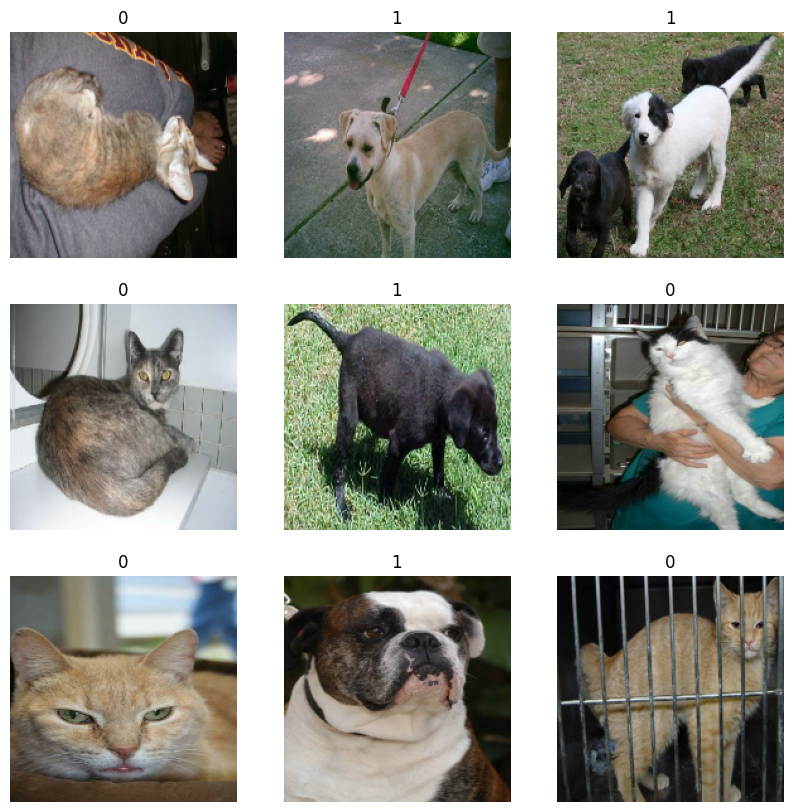

In [4]:
#Visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

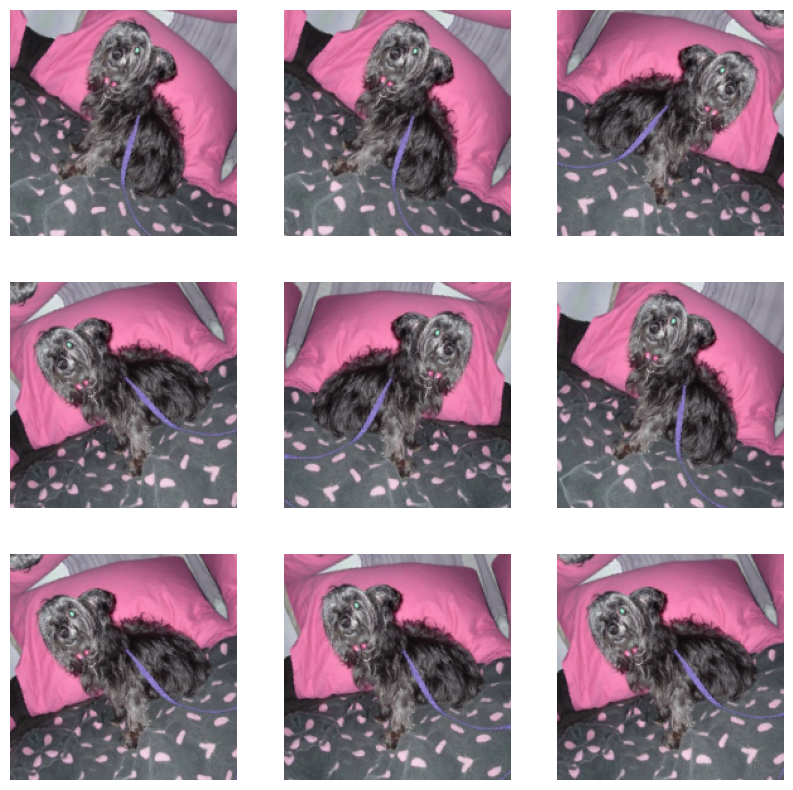

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
# 2번 옵션
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [8]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
epochs = 0  # 빠른 종료를 위해 1로 설정

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

In [11]:
img = keras.utils.load_img(
    "PetImages/Cat/0.jpg", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 272ms/step
This image is 50.01% cat and 49.99% dog.


2023-08-06 18:55:13.411677: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/activation_5/Relu' exist for missing node 'model/add/add'.
2023-08-06 18:55:13.429461: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/activation_5/Relu' exist for missing node 'model/add/add'.


In [12]:
model.save('cats_dogs.h5')

/home/gang/miniconda3/envs/sqler_lec/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# 모델을 로드하고 예측 수행
new_model = tf.keras.models.load_model('cats_dogs.h5')

In [14]:
# test_loss, test_acc = new_model.evaluate(x,  y, verbose=2)
image_size = (180, 180)

img = keras.utils.load_img(
    "PetImages/Cat/0.jpg", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = new_model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 208ms/step
This image is 50.01% cat and 49.99% dog.


2023-08-06 18:55:19.386114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/add_2/add' exist for missing node 'model/add_1/add'.
2023-08-06 18:55:19.405407: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/add_2/add' exist for missing node 'model/add_1/add'.
